## <center>Projet VitaliTaxi</center>
## <center>Les courses de taxi New-Yorkais</center>

## Partie 1 : Exploration et Préparation des données

### 1. Importation des données des courses de taxi jaunes

Pour commencer on va importer les bibliothèque nécessaires 

In [12]:
#!pip install pyarrow

In [28]:
import pandas as pd # bibliothèque de manipulation de données tabulaires
import numpy as np #  bibliothèque de manipulation des tableaux de données multidimensionnels
import matplotlib.pyplot as plt # bibliothèque de visualisation de données
import seaborn as sns #  bibliothèque de visualisation de données : graphiques statistiques
import pyarrow.parquet as pq

On importe les données yellow_tripdata_2023-03

In [29]:
trips = pq.read_table('yellow_tripdata_2023-03.parquet')
trips = trips.to_pandas()

print("Nombre de lignes : " , trips.shape[0])
print("Nombre de variables : ",trips.shape[1] )


Nombre de lignes :  3403766
Nombre de variables :  19


In [30]:
trips.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2023-03-01 00:06:43,2023-03-01 00:16:43,1.0,0.00,1.0,N,238,42,2,8.6,1.0,0.5,0.00,0.0,1.0,11.10,0.0,0.00
1,2,2023-03-01 00:08:25,2023-03-01 00:39:30,2.0,12.40,1.0,N,138,231,1,52.7,6.0,0.5,12.54,0.0,1.0,76.49,2.5,1.25
2,1,2023-03-01 00:15:04,2023-03-01 00:29:26,0.0,3.30,1.0,N,140,186,1,18.4,3.5,0.5,4.65,0.0,1.0,28.05,2.5,0.00
3,1,2023-03-01 00:49:37,2023-03-01 01:01:05,1.0,2.90,1.0,N,140,43,1,15.6,3.5,0.5,4.10,0.0,1.0,24.70,2.5,0.00
4,2,2023-03-01 00:08:04,2023-03-01 00:11:06,1.0,1.23,1.0,N,79,137,1,7.2,1.0,0.5,2.44,0.0,1.0,14.64,2.5,0.00


Description des Données

In [31]:
print(trips.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3403766 entries, 0 to 3403765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

### 2. Exploration et visualisation des données

In [32]:
print(trips.describe())

           VendorID  passenger_count  trip_distance    RatecodeID  \
count  3.403766e+06     3.316147e+06   3.403766e+06  3.316147e+06   
mean   1.725320e+00     1.351417e+00   3.903871e+00  1.623961e+00   
std    4.588677e-01     8.861919e-01   1.916866e+02  7.358691e+00   
min    1.000000e+00     0.000000e+00   0.000000e+00  1.000000e+00   
25%    1.000000e+00     1.000000e+00   1.050000e+00  1.000000e+00   
50%    2.000000e+00     1.000000e+00   1.790000e+00  1.000000e+00   
75%    2.000000e+00     1.000000e+00   3.380000e+00  1.000000e+00   
max    6.000000e+00     9.000000e+00   2.169870e+05  9.900000e+01   

       PULocationID  DOLocationID  payment_type   fare_amount         extra  \
count  3.403766e+06  3.403766e+06  3.403766e+06  3.403766e+06  3.403766e+06   
mean   1.654540e+02  1.641003e+02  1.187310e+00  1.890845e+01  1.629128e+00   
std    6.373958e+01  6.967282e+01  5.334025e-01  1.825637e+01  1.842778e+00   
min    1.000000e+00  1.000000e+00  0.000000e+00 -9.599000e+02 

#### 2.1 Valeurs Manquantes

Visualisation des données manquantes

<AxesSubplot:>

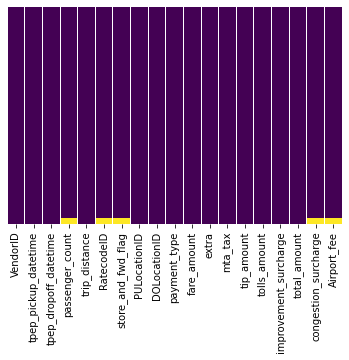

In [33]:
sns.heatmap(trips.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Compter les valeurs manquantes par variable

In [23]:
missing_values = trips.isnull().sum()
print(missing_values)

VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          87619
trip_distance                0
RatecodeID               87619
store_and_fwd_flag       87619
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     87619
Airport_fee              87619
dtype: int64


#### 2.2 Visualisation des Variables

In [36]:
trips.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2023-03-01 00:06:43,2023-03-01 00:16:43,1.0,0.00,1.0,N,238,42,2,8.6,1.0,0.5,0.00,0.0,1.0,11.10,0.0,0.00
1,2,2023-03-01 00:08:25,2023-03-01 00:39:30,2.0,12.40,1.0,N,138,231,1,52.7,6.0,0.5,12.54,0.0,1.0,76.49,2.5,1.25
2,1,2023-03-01 00:15:04,2023-03-01 00:29:26,0.0,3.30,1.0,N,140,186,1,18.4,3.5,0.5,4.65,0.0,1.0,28.05,2.5,0.00
3,1,2023-03-01 00:49:37,2023-03-01 01:01:05,1.0,2.90,1.0,N,140,43,1,15.6,3.5,0.5,4.10,0.0,1.0,24.70,2.5,0.00
4,2,2023-03-01 00:08:04,2023-03-01 00:11:06,1.0,1.23,1.0,N,79,137,1,7.2,1.0,0.5,2.44,0.0,1.0,14.64,2.5,0.00


In [56]:
sns.countplot(x='payment_type', hue='Total_amount', data=trips)
plt.show()

ValueError: Could not interpret input 'Total_amount'

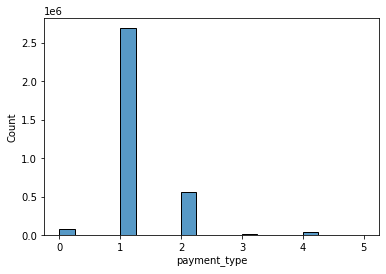

In [44]:
sns.histplot(trips["payment_type"], bins=20, kde=False)
plt.show()

C:\tools\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


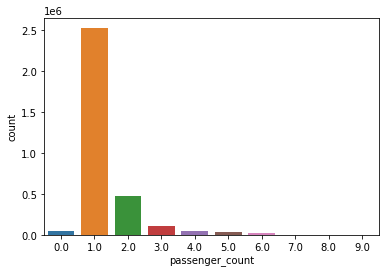

In [53]:
sns.countplot(trips["passenger_count"])
plt.show()

In [ ]:
trips.drop(['Airport_fee','congestion_surcharge','improvement_surcharge','tolls_amount','tip_amount','mta_tax','extra','fare_amount'], axis = 1, inplace = True)

In [8]:
print(trips.drop)

<bound method DataFrame.drop of          VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0               2  2023-03-01 00:06:43   2023-03-01 00:16:43              1.0   
1               2  2023-03-01 00:08:25   2023-03-01 00:39:30              2.0   
2               1  2023-03-01 00:15:04   2023-03-01 00:29:26              0.0   
3               1  2023-03-01 00:49:37   2023-03-01 01:01:05              1.0   
4               2  2023-03-01 00:08:04   2023-03-01 00:11:06              1.0   
...           ...                  ...                   ...              ...   
3403761         2  2023-03-31 23:24:25   2023-03-31 23:40:54              NaN   
3403762         2  2023-03-31 23:24:50   2023-04-01 00:04:12              NaN   
3403763         2  2023-03-31 23:26:31   2023-03-31 23:49:39              NaN   
3403764         2  2023-03-31 23:07:51   2023-03-31 23:15:56              NaN   
3403765         2  2023-03-31 23:26:12   2023-03-31 23:31:47              NaN